# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
# Unity ml-agents path
import sys
sys.path.append("../python/")

In [3]:
from unityagents import UnityEnvironment
import numpy as np

In [4]:
env = UnityEnvironment(file_name="../Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
import maddpg_v2
from imp import reload
reload(maddpg_v2)
from maddpg_v2 import *


In [10]:
###### from maddpg_agent import *

import matplotlib.pyplot as plt
%matplotlib inline
import time


def train(n_episodes=500, max_t=1000, random_seed=1, agent=None, debug=False):
    if agent == None:
        agent = [Agent(state_size=state_size, action_size=action_size, 
                          random_seed=random_seed, 
                       num_agents=num_agents, agent_index=i) for i in range(num_agents)]
    else:
        for i in range(num_agents):
            agent[i].memory = PERMemory(BUFFER_SIZE, random_seed)
            agent[i].reset()
        
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_plot = []
    scores_ave = []
    scores_agent = []
    c_loss_plot = [[] for i in range(num_agents)]
    a_loss_plot = [[] for i in range(num_agents)]
    total_t = 0
    
    for i_episode in range(1, n_episodes + 1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        for i in range(num_agents):
            agent[i].reset()
        time_start = time.time()
        
        temp_states = []
        temp_actions = []
        temp_rewards = []
        temp_next_states = []
        temp_dones = []
        temp_t = []
        
        for _ in range(max_t):
            total_t += 1
            temp_t.append(total_t)
            actions = [agent[i].act(states) for i in range(num_agents)]
            actions = np.vstack(actions)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done  # see if episode has finished
            states = next_states
            scores += rewards

            temp_states.append(states)
            temp_actions.append(actions)
            temp_rewards.append(rewards)
            temp_next_states.append(next_states)
            temp_dones.append(dones)

            if np.any(np.array(rewards) > 0):
                temp_rewards = (torch.from_numpy(np.array(temp_rewards)) + torch.from_numpy(np.array(rewards))).cpu().data.numpy()
                if len(temp_states) > 0:
                    for s, a, r, ns, d, t in zip(temp_states, temp_actions, temp_rewards, temp_next_states, temp_dones, temp_t):
                        for i in range(num_agents):
                            c_loss, a_loss = agent[i].step(s, a, r[i], ns, d[i], timestep=t)
                            if len(c_loss) > 0: 
                                c_loss_plot[i] += c_loss
                            if len(a_loss) > 0: 
                                a_loss_plot[i] += a_loss
                    temp_states = []
                    temp_actions = []
                    temp_rewards = []
                    temp_next_states = []
                    temp_dones = []
                    temp_t = []
                            
            if np.any(dones):
                if len(temp_states) > 0:
                    for s, a, r, ns, d, t in zip(temp_states, temp_actions, temp_rewards, temp_next_states, temp_dones, temp_t):
                        for i in range(num_agents):
                            c_loss, a_loss = agent[i].step(s, a, r[i], ns, d[i], timestep=t)
                            if len(c_loss) > 0: 
                                c_loss_plot[i] += c_loss
                            if len(a_loss) > 0: 
                                a_loss_plot[i] += a_loss
                break
            
        duration = time.time() - time_start
        scores_window.append(np.mean(scores))  # save most recent score
        scores_plot.append(np.mean(scores))
        scores_ave.append(np.mean(scores_window))
        scores_agent.append(scores)
                
        print('\rEpisode {}({}sec)\t MIN:{:.2f} MAX:{:.2f} MEAN:{:.2f} MEANo100:{:.2f} Batch Size: {} {}'.format(i_episode, 
                                    round(duration), np.min(scores), 
                                     np.max(scores), np.mean(scores), 
                                     np.mean(scores_window), 
                                     format(len(agent[0].memory)), ' '*10), end="")
        if i_episode % 100 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}\
                \tTimestep: {}'.format(i_episode, 
                                       np.mean(scores_window), 
                                       total_t))
            # plot the scores
            fig, ax = plt.subplots()
            
            plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
            for i in range(num_agents):
                plt.plot(np.arange(len(np.vstack(scores_agent))), 
                         np.vstack(scores_agent)[:,i], label='Agent {}'.format(i+1))
            plt.plot(np.arange(len(scores_plot)), scores_plot, label='Score Ave')
            plt.xlabel('Episode #')
            ax.legend()
            plt.show()
            
            if len(np.array(c_loss_plot).reshape(-1)):
                # c loss
#                 print(c_loss_plot)
                c_loss_agents = np.array(c_loss_plot).reshape(num_agents, -1)
#                 print(c_loss_agents)
                fig, ax = plt.subplots()
                for i in range(num_agents):
                    plt.plot(np.arange(len(c_loss_agents[i])), c_loss_agents[i], label='Agent {}'.format(i+1))
                plt.xlabel('Learn #')
                plt.ylabel('Q')
                ax.legend()
                plt.show()
            
            if len(np.array(a_loss_plot).reshape(-1)):
                # a loss
                a_loss_agents = np.array(a_loss_plot).reshape(num_agents, -1)
                fig, ax = plt.subplots()
                for i in range(num_agents):
                    plt.plot(np.arange(len(a_loss_agents[i])), a_loss_agents[i], label='Agent {}'.format(i+1))
                plt.xlabel('Learn #')
                plt.ylabel('Policy')
                ax.legend()
                plt.show()
            
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'actor{}_{}.pth'.format(i, i_episode))
                torch.save(agent[i].critic_local.state_dict(), 'critic{}_{}.pth'.format(i, i_episode))

        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'actor{}.pth'.format(i))
                torch.save(agent[i].critic_local.state_dict(), 'critic{}.pth'.format(i))
            break
            
    return scores_ave, agent


#### Sanity test

```python
# TEST
BUFFER_SIZE = 32
BATCH_SIZE = 8         # minibatch size
LEARN_EVERY = 1       # learning timestep interval
LEARN_NUM = 1           # number of learning passes
LEARN_AFTER = 0
```

In [13]:
import maddpg_v2
from imp import reload
reload(maddpg_v2)
from maddpg_v2 import *

In [14]:
train(n_episodes=4)

Episode 4(5sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 32           

([-0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291],
 [<maddpg_v2.Agent at 0xbac92e8>, <maddpg_v2.Agent at 0xbb43978>])

In [15]:
def play(play_agent, t=10, noise=False):
    # trained model
    # play times
    for i in range(t):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        step = 0
        while True:
#             actions = play_agent.act(states, add_noise=False)                  # all actions between -1 and 1
            step += 1
            actions = [ play_agent[i].act(states, add_noise=noise) for i in range(num_agents) ]
            actions = np.vstack(actions)
#             print('actions', actions)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
#             print('step', step, 'rewards', rewards)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
#             time.sleep(0.5)
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (sum over agents) from episode {}: {:.2f}'.format(i, np.sum(scores)))

#### Experiment 11

```python
BUFFER_SIZE = 2**17  # replay buffer size
BATCH_SIZE = 512         # minibatch size
GAMMA = 0.95            # discount factor
TAU_ACTOR = 1e-3              # for soft update of target parameters
TAU_CRITIC = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 1        # learning timestep interval
LEARN_NUM = 10           # number of learning passes
LEARN_AFTER = 2000
SEED = 1

```

In [50]:
import maddpg_v2
from imp import reload
reload(maddpg_v2)
from maddpg_v2 import *

Episode 100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 1770           
Episode 100	Average Score: 0.00                	Timestep: 1770


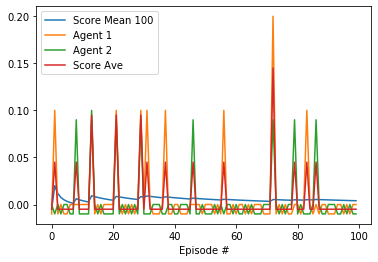

Episode 200(37sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 3413            
Episode 200	Average Score: 0.00                	Timestep: 3413


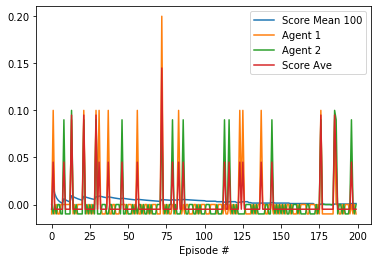

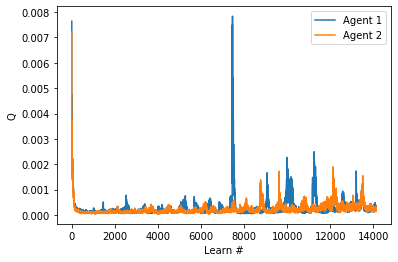

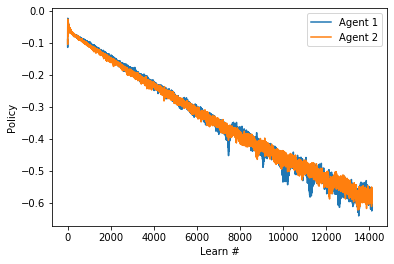

Episode 300(32sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 5175           
Episode 300	Average Score: 0.00                	Timestep: 5175


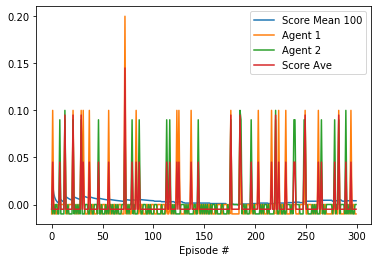

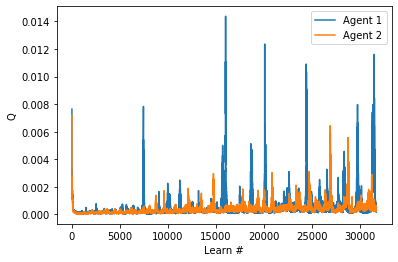

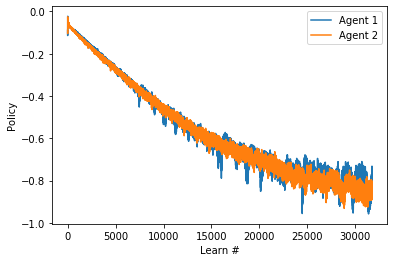

Episode 400(33sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 6835           
Episode 400	Average Score: 0.00                	Timestep: 6835


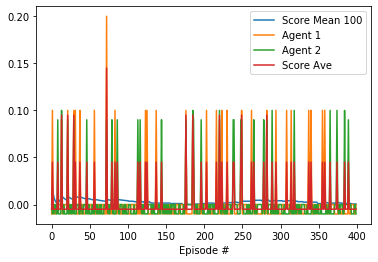

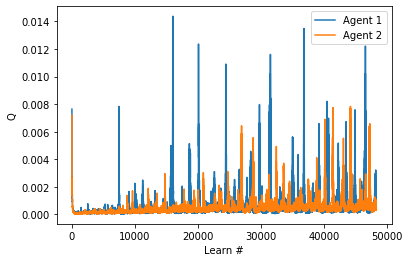

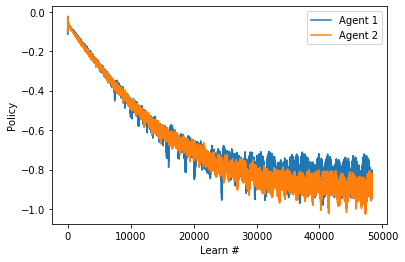

Episode 500(68sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.01 Batch Size: 8880            
Episode 500	Average Score: 0.01                	Timestep: 8880


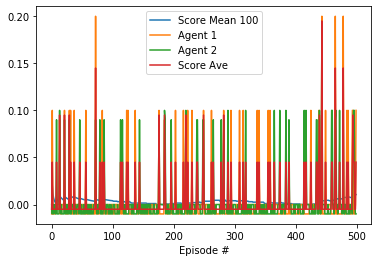

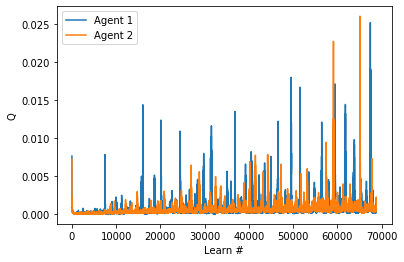

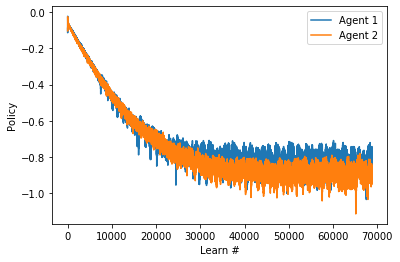

Episode 600(33sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.02 Batch Size: 11224           
Episode 600	Average Score: 0.02                	Timestep: 11224


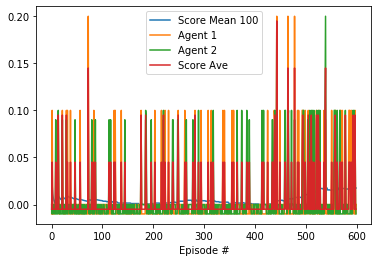

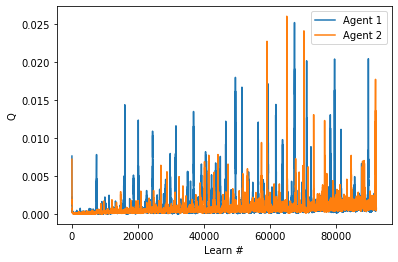

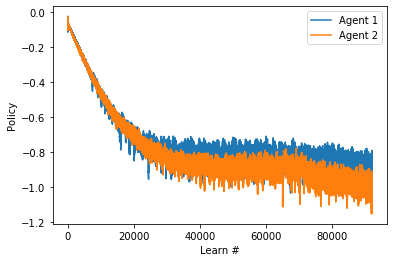

Episode 700(114sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.02 Batch Size: 13561           
Episode 700	Average Score: 0.02                	Timestep: 13561


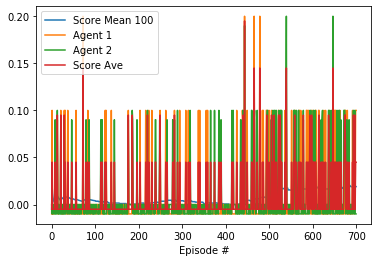

C:\ProgramData\Anaconda3\envs\ml-agents\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


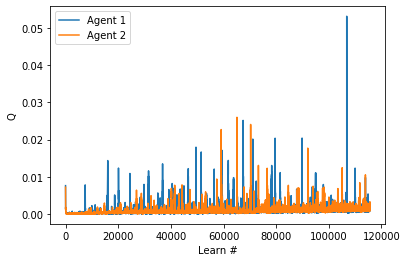

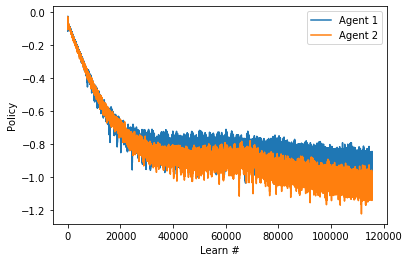

Episode 800(61sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.03 Batch Size: 16323            
Episode 800	Average Score: 0.03                	Timestep: 16323


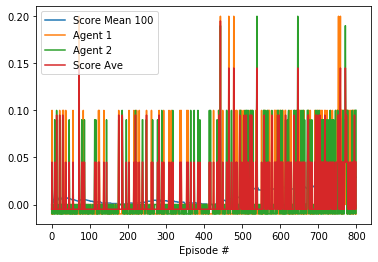

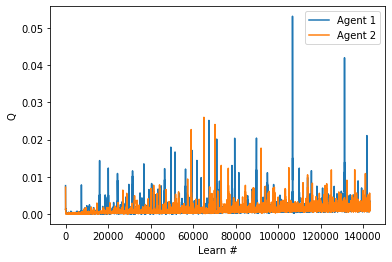

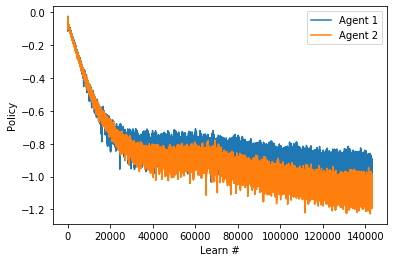

Episode 900(72sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.02 Batch Size: 18998            
Episode 900	Average Score: 0.02                	Timestep: 18998


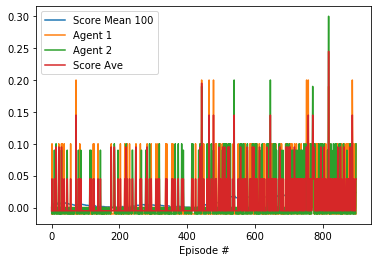

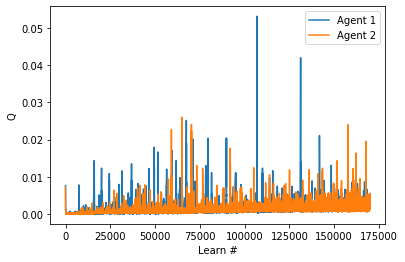

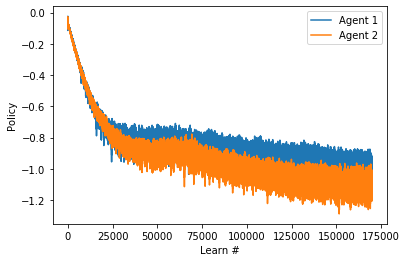

Episode 1000(75sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.02 Batch Size: 21484           
Episode 1000	Average Score: 0.02                	Timestep: 21484


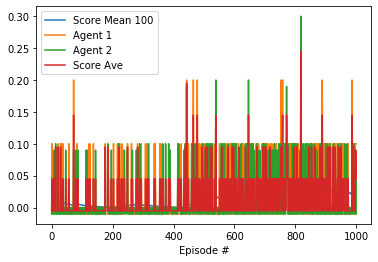

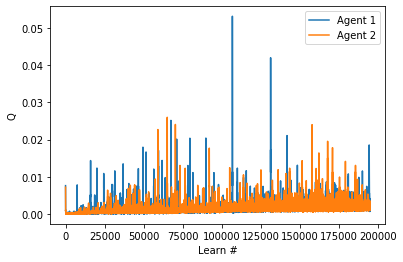

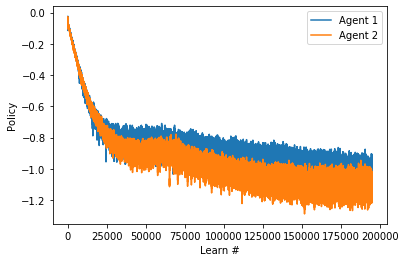

Episode 1100(36sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.01 Batch Size: 23667           
Episode 1100	Average Score: 0.01                	Timestep: 23667


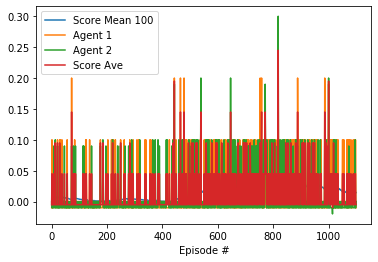

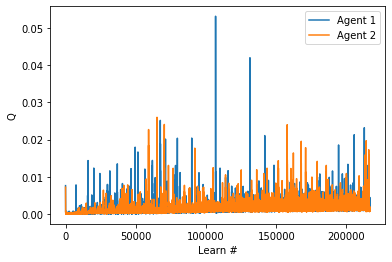

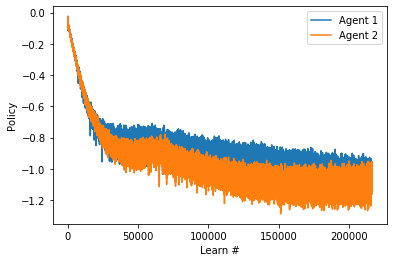

Episode 1111(74sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.01 Batch Size: 23879            

KeyboardInterrupt: 

In [51]:
scores_ave, agent = train(n_episodes=2000, random_seed=SEED)

#### Experiment 12

```python

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.95            # discount factor
TAU_ACTOR = 1e-2              # for soft update of target parameters
TAU_CRITIC = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 1        # learning timestep interval
LEARN_NUM = 5           # number of learning passes
LEARN_AFTER = 2000
SEED = 1

```

In [50]:
import maddpg_v2
from imp import reload
reload(maddpg_v2)
from maddpg_v2 import *

Episode 100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 1765           
Episode 100	Average Score: 0.00                	Timestep: 1765


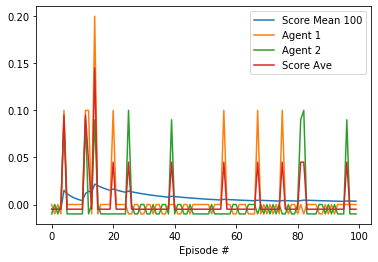

Episode 200(12sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 3346           
Episode 200	Average Score: -0.00                	Timestep: 3346


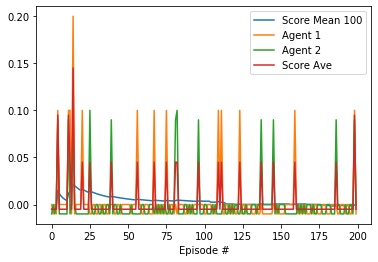

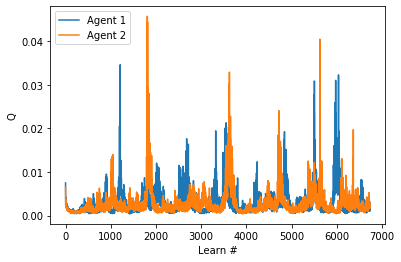

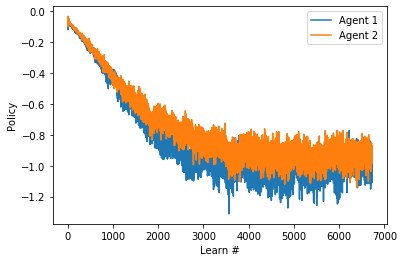

Episode 300(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 5003            
Episode 300	Average Score: 0.00                	Timestep: 5003


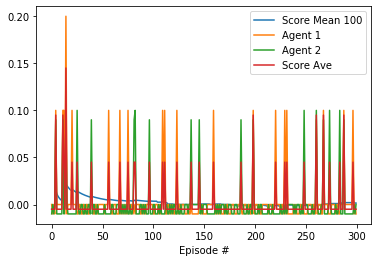

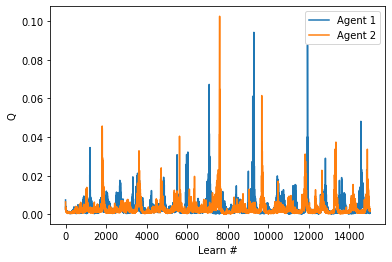

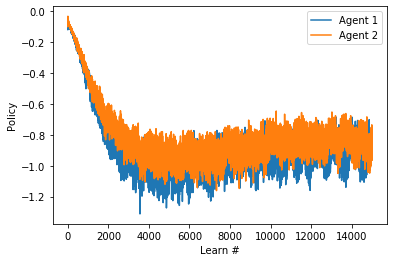

Episode 400(12sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.01 Batch Size: 6832           
Episode 400	Average Score: 0.01                	Timestep: 6832


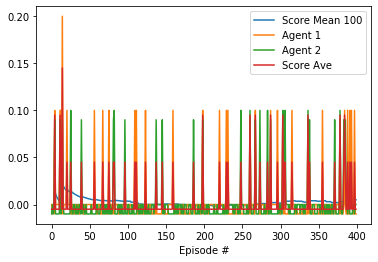

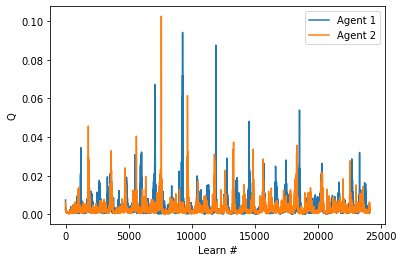

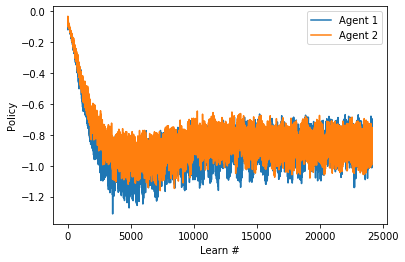

Episode 500(12sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 8511           
Episode 500	Average Score: 0.00                	Timestep: 8511


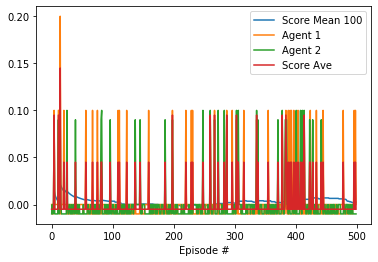

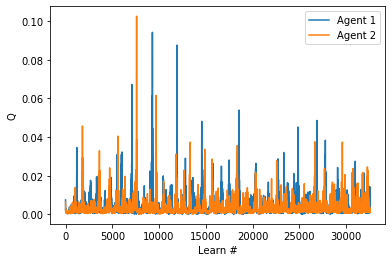

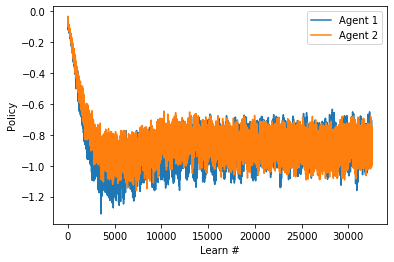

Episode 600(28sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:-0.00 Batch Size: 10054            
Episode 600	Average Score: -0.00                	Timestep: 10054


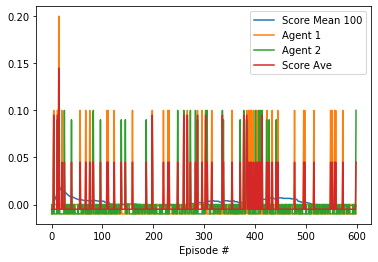

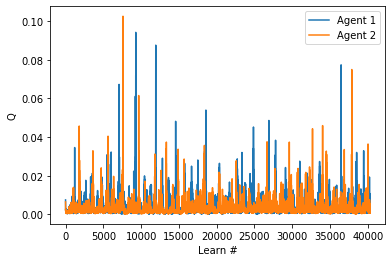

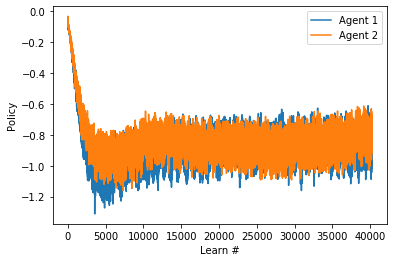

Episode 700(24sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.01 Batch Size: 12138             
Episode 700	Average Score: 0.01                	Timestep: 12138


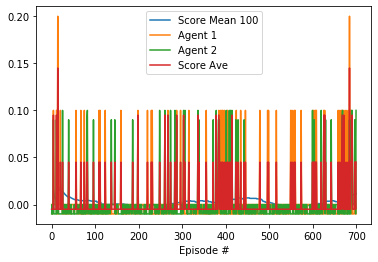

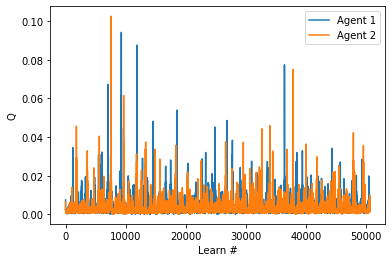

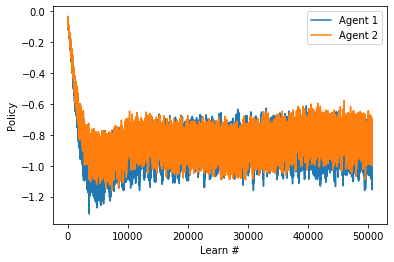

Episode 800(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.03 Batch Size: 14947           
Episode 800	Average Score: 0.03                	Timestep: 14947


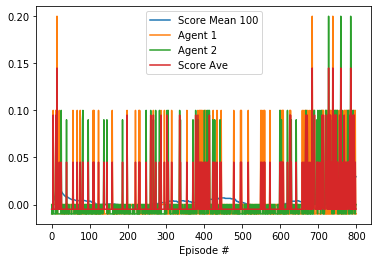

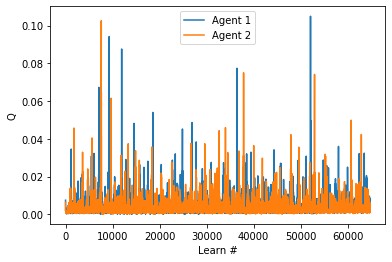

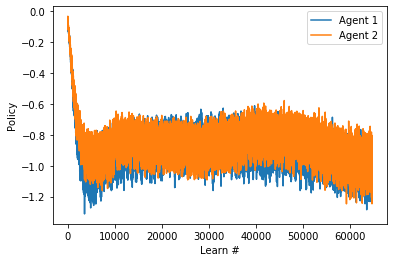

Episode 900(53sec)	 MIN:0.09 MAX:0.20 MEAN:0.15 MEANo100:0.04 Batch Size: 18014             
Episode 900	Average Score: 0.04                	Timestep: 18014


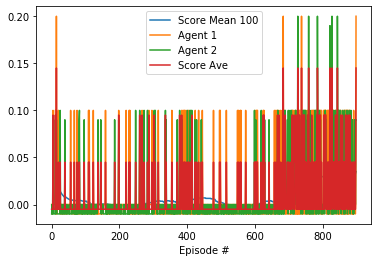

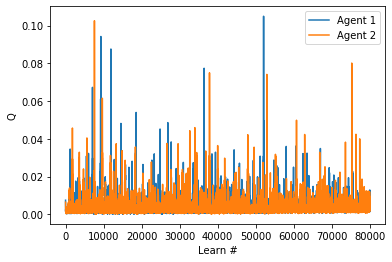

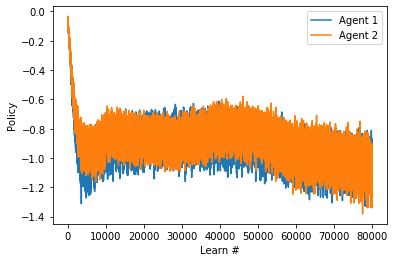

Episode 1000(13sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.05 Batch Size: 21539           
Episode 1000	Average Score: 0.05                	Timestep: 21539


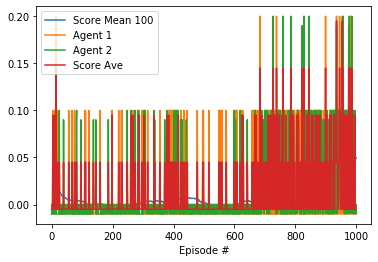

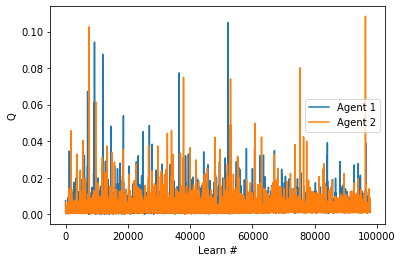

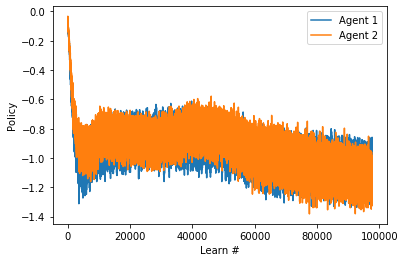

Episode 1100(26sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.04 Batch Size: 24461            
Episode 1100	Average Score: 0.04                	Timestep: 24461


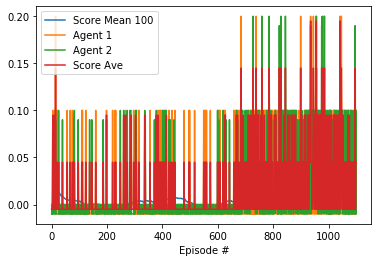

C:\ProgramData\Anaconda3\envs\ml-agents\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


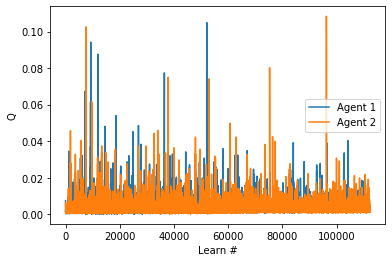

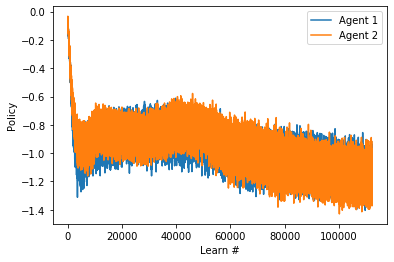

Episode 1200(47sec)	 MIN:0.09 MAX:0.10 MEAN:0.10 MEANo100:0.03 Batch Size: 27286             
Episode 1200	Average Score: 0.03                	Timestep: 27286


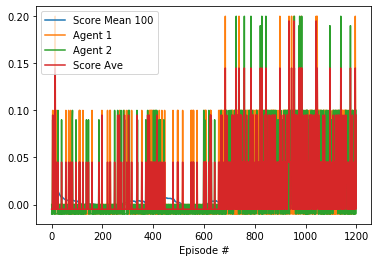

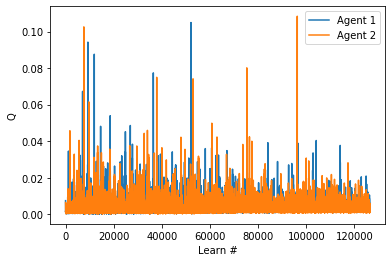

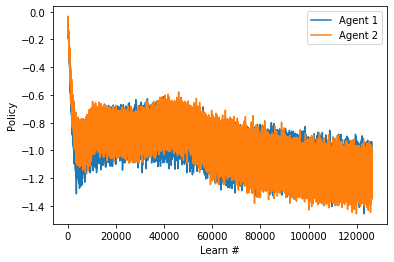

Episode 1300(24sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.02 Batch Size: 29667            
Episode 1300	Average Score: 0.02                	Timestep: 29667


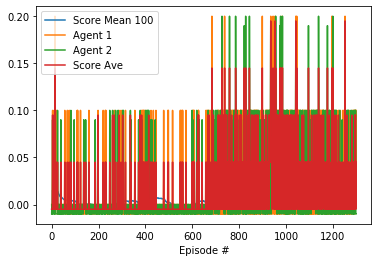

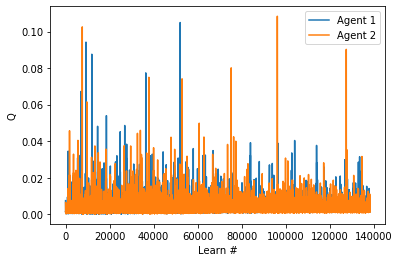

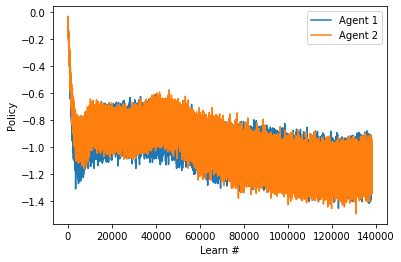

Episode 1400(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.03 Batch Size: 32290           
Episode 1400	Average Score: 0.03                	Timestep: 32290


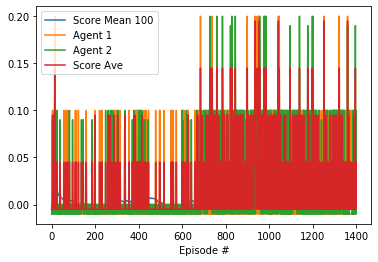

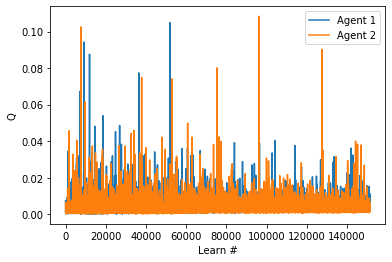

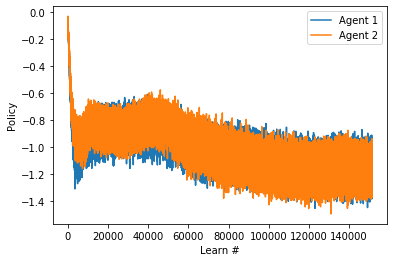

Episode 1500(24sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.03 Batch Size: 34854            
Episode 1500	Average Score: 0.03                	Timestep: 34854


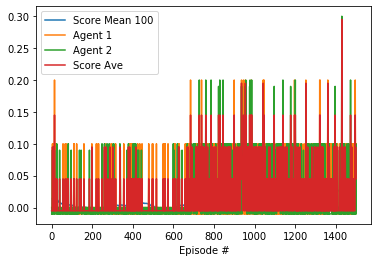

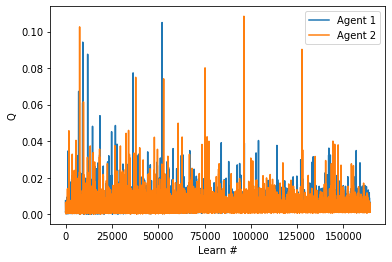

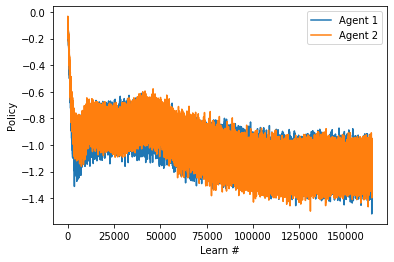

Episode 1600(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.03 Batch Size: 37619           
Episode 1600	Average Score: 0.03                	Timestep: 37619


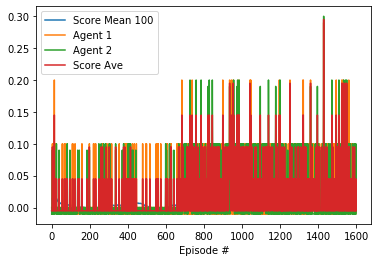

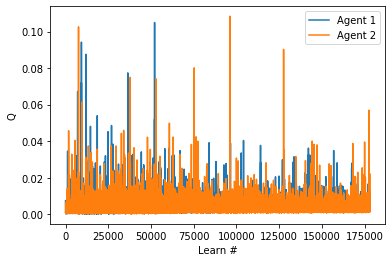

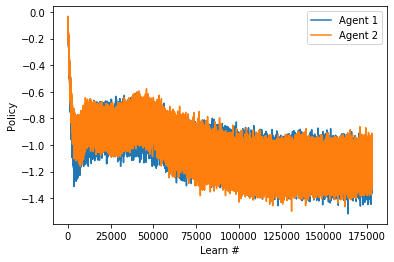

Episode 1700(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.02 Batch Size: 40122           
Episode 1700	Average Score: 0.02                	Timestep: 40122


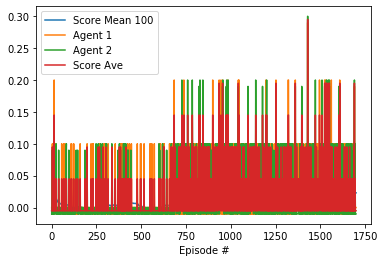

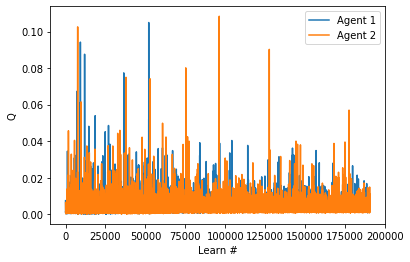

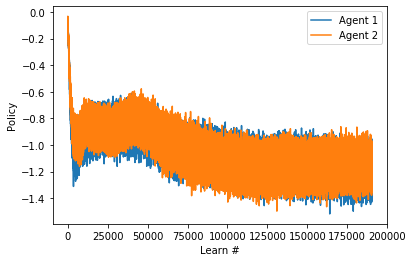

Episode 1800(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.04 Batch Size: 43148           
Episode 1800	Average Score: 0.04                	Timestep: 43148


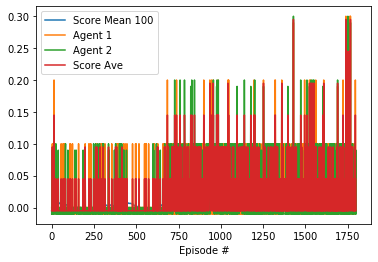

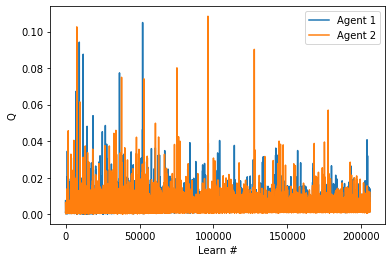

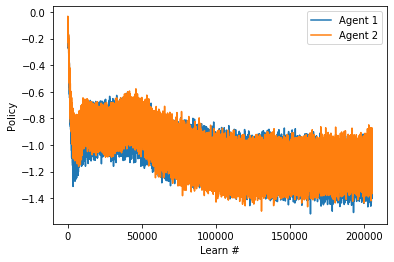

Episode 1900(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.04 Batch Size: 46381           
Episode 1900	Average Score: 0.04                	Timestep: 46381


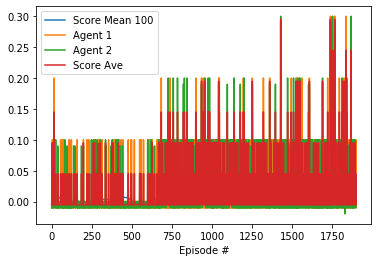

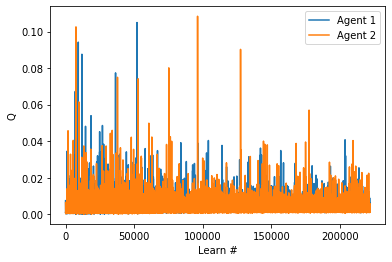

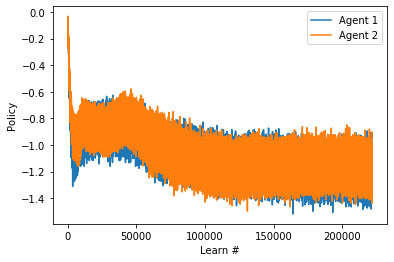

Episode 2000(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.03 Batch Size: 49350           
Episode 2000	Average Score: 0.03                	Timestep: 49350


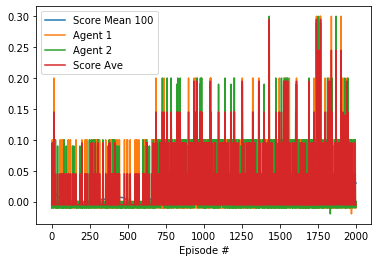

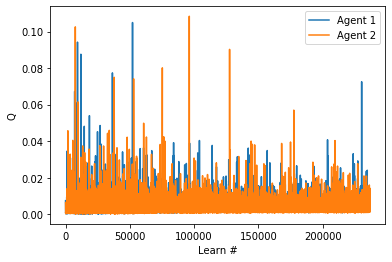

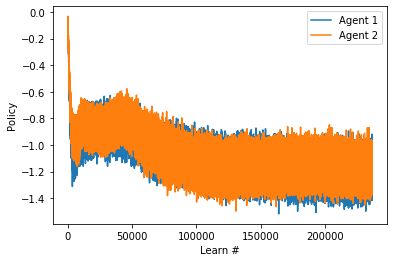

In [13]:
scores_ave, agent = train(n_episodes=2000, random_seed=SEED)

In [19]:
play(agent, noise=True)

Score (sum over agents) from episode 0: -0.01
Score (sum over agents) from episode 1: -0.01
Score (sum over agents) from episode 2: -0.01
Score (sum over agents) from episode 3: 0.09
Score (sum over agents) from episode 4: 0.09
Score (sum over agents) from episode 5: -0.01
Score (sum over agents) from episode 6: -0.01
Score (sum over agents) from episode 7: -0.01
Score (sum over agents) from episode 8: -0.01
Score (sum over agents) from episode 9: 0.09
